<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/Prototype_Model/one_hot_DNN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

one-hotベクトルの次元数が増える場合はエンベディングするのがベストといわれてる：https://www.tensorflow.org/tutorials/structured_data/feature_columns
カテゴリ列はstring_int layerを前処理で、embeddinglayerをモデルに採用
カテゴリ列以外は、標準化レイヤーをモデルに採用

In [1]:
%pip show tensorflow scikit-learn

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, wheel, opt-einsum, scipy, protobuf, tensorflow-estimator, h5py, gast, google-pasta, astunparse, six, grpcio, keras-preprocessing, wrapt, termcolor, absl-py, tensorboard
Required-by: fancyimpute
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, joblib, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


[国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [5]:
import datetime, IPython, os 

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import Model, Input, layers, optimizers, callbacks
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import plot_model

# データ読み込み

In [41]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)
X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _one_hot_encode(y):
        '''ワンホットエンコードしたnumpy.ndarrayを返す'''
        return pd.get_dummies(y)

    proc_y = _one_hot_encode(y=y)
    return proc_y


def proc_X(X, one_hot_encode_cols):
    '''特徴量の加工'''
    def _one_hot_encode(X, X_cols, drop_first=True):
        '''ワンホットエンコードしたDataframeを返す'''
        return pd.get_dummies(X, columns=X_cols,
                              drop_first=drop_first)

    proc_X = _one_hot_encode(X=X, X_cols=one_hot_encode_cols)
    return proc_X


one_hot_encode_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
numericla_cols =  set(X.columns) ^ set(one_hot_encode_cols)
X=proc_X(X=X, one_hot_encode_cols=one_hot_encode_cols)
y=proc_y(y=y)

display(X.head())
display(y.head())


# 数値型の特徴量とワンホットエンコード型の特徴量の分離
# INFO : 数値型とワンホットエンコード型の特徴量が混在していると標準化がうまくできない
def separate_numerical_X_and_one_hot_X(X, numericla_cols):
    '''数値型の特徴量とワンホットエンコード型の特徴量を分離する
    
    Parameters
    -----
    X : pandas.Dataframe
    numericla_cols : list of string
      数値型のデータが格納されている列名
    
    Returns
    -----
    numerical_X : pandas.Dataframe
    one_hot_X : pandas.Dataframe
    '''
    cols = X.columns
    one_hot_cols = set(cols) ^ set(numericla_cols)
    
    numerical_X = X.loc[:,numericla_cols]
    one_hot_X = X.loc[:,one_hot_cols]
    return numerical_X, one_hot_X


numerical_X, one_hot_X = separate_numerical_X_and_one_hot_X(X, numericla_cols)
display(numerical_X.head())
display(one_hot_X.head())


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_num_X, test_num_X, train_one_hot_X, test_one_hot_X, train_y, test_y = train_test_split(numerical_X.values, one_hot_X.values, y,
                                                                                              test_size=SPLIT,
                                                                                              random_state=SEED,
                                                                                              shuffle=True)
train_num_X, val_num_X, train_one_hot_X, val_one_hot_X, train_y, val_y = train_test_split(train_num_X, train_one_hot_X, train_y,
                                                                                          test_size=SPLIT,
                                                                                          random_state=SEED,
                                                                                          shuffle=True)
def create_dictionary(values, keys):
    '''辞書型のオブジェクト作成'''
    obj = {}
    for val, key in zip(values, keys):
        obj[key] = val
    return obj

numerical_key = 'numerical_X'
one_hot_key = 'one_hot_X'
keys = [numerical_key, one_hot_key]
train_X = create_dictionary(values=[train_num_X, train_one_hot_X], keys=keys)
val_X = create_dictionary(values=[val_num_X, val_one_hot_X], keys=keys)
test_X = create_dictionary(values=[test_num_X, test_one_hot_X], keys=keys)

display('train_X numerical shape:{}'.format(train_X[numerical_key].shape))
display('val_X numerical shape:{}'.format(val_X[numerical_key].shape))
display('test_X numerical shape:{}'.format(test_X[numerical_key].shape))

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,workclass_Local-gov,workclass_State-gov,workclass_Without-pay,workclass_Never-worked,education_Some-college,education_11th,education_HS-grad,education_Prof-school,education_Assoc-acdm,education_Assoc-voc,education_9th,education_7th-8th,education_12th,education_Masters,education_1st-4th,education_10th,education_Doctorate,education_5th-6th,education_Preschool,marital-status_Divorced,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Other-service,occupation_Sales,occupation_Exec-managerial,occupation_Prof-specialty,occupation_Handlers-cleaners,...,native-country_Cambodia,native-country_England,native-country_Puerto-Rico,native-country_Canada,native-country_Germany,native-country_Outlying-US(Guam-USVI-etc),native-country_India,native-country_Japan,native-country_Greece,native-country_South,native-country_China,native-country_Cuba,native-country_Iran,native-country_Honduras,native-country_Philippines,native-country_Italy,native-country_Poland,native-country_Jamaica,native-country_Vietnam,native-country_Mexico,native-country_Portugal,native-country_Ireland,native-country_France,native-country_Dominican-Republic,native-country_Laos,native-country_Ecuador,native-country_Taiwan,native-country_Haiti,native-country_Columbia,native-country_Hungary,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,>50K,<=50K
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


,age,capital-loss,fnlwgt,education-num,capital-gain,hours-per-week
0,25.0,0.0,226802.0,7.0,0.0,40.0
1,38.0,0.0,89814.0,9.0,0.0,50.0
2,28.0,0.0,336951.0,12.0,0.0,40.0
3,44.0,0.0,160323.0,10.0,7688.0,40.0
4,18.0,0.0,103497.0,10.0,0.0,30.0


,occupation_Craft-repair,native-country_Trinadad&Tobago,marital-status_Separated,occupation_Machine-op-inspct,education_12th,native-country_Scotland,education_Assoc-voc,occupation_Other-service,race_Black,education_5th-6th,education_11th,workclass_Never-worked,education_Masters,marital-status_Married-spouse-absent,native-country_Italy,native-country_India,education_10th,education_Assoc-acdm,marital-status_Divorced,native-country_Japan,relationship_Not-in-family,education_Some-college,workclass_Self-emp-not-inc,native-country_Cuba,native-country_Poland,native-country_South,marital-status_Widowed,marital-status_Never-married,marital-status_Married-AF-spouse,native-country_Canada,education_Prof-school,occupation_Protective-serv,native-country_Guatemala,education_9th,native-country_Greece,occupation_Sales,occupation_Adm-clerical,native-country_Jamaica,workclass_Federal-gov,education_HS-grad,...,occupation_Transport-moving,native-country_Thailand,race_Asian-Pac-Islander,relationship_Unmarried,native-country_Haiti,sex_Male,native-country_Mexico,workclass_Local-gov,occupation_Priv-house-serv,native-country_Hungary,native-country_Vietnam,occupation_Handlers-cleaners,native-country_Holand-Netherlands,native-country_Outlying-US(Guam-USVI-etc),native-country_France,native-country_Hong,native-country_Honduras,native-country_Portugal,native-country_Laos,native-country_Cambodia,occupation_Prof-specialty,workclass_Without-pay,workclass_State-gov,occupation_Exec-managerial,native-country_Columbia,native-country_Nicaragua,native-country_Germany,native-country_Iran,native-country_China,education_7th-8th,relationship_Own-child,native-country_England,native-country_El-Salvador,native-country_Peru,occupation_Farming-fishing,relationship_Husband,relationship_Other-relative,race_Amer-Indian-Eskimo,native-country_Yugoslavia,native-country_Dominican-Republic
0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


'train_X numerical shape:(31258, 6)'

'val_X numerical shape:(7815, 6)'

'test_X numerical shape:(9769, 6)'

CPU times: user 1.62 s, sys: 84.4 ms, total: 1.7 s
Wall time: 1.7 s


# モデル構築

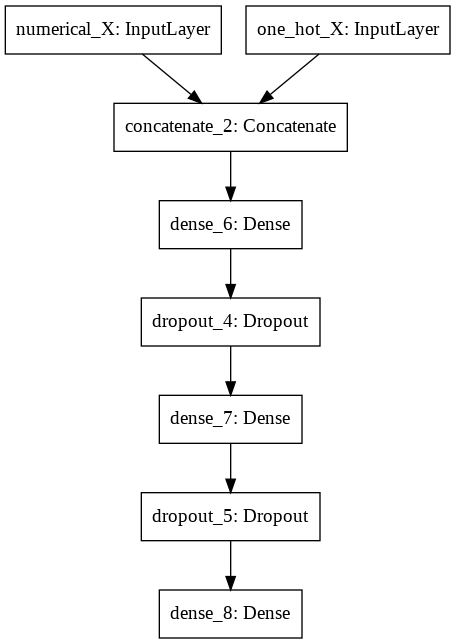

CPU times: user 95.8 ms, sys: 14.1 ms, total: 110 ms
Wall time: 150 ms


In [42]:
%%time
def model_fn(train_numerical_X, one_hot_dim, num_class, dropout_seed=None):
    '''モデルの構造定義
    
    Parameters
    -----
    train_numerical_X : numpy.ndarray
      標準化レイヤーに適合させる数値型の特徴量
    one_hot_dim : int or tuple
      ワンホットエンコードしている次元数
    num_class : int
      分類するクラス数
    dropout_seed : float (default : None)
    '''

    def _setup_norm_layer(adapt_X):
        '''標準化レイヤーのセットアップ'''
        norm_layer = Normalization()
        norm_layer.adapt(adapt_X)
        return norm_layer


    # 数値データ用の入力層
    input_shape = train_numerical_X.shape[1]
    numerical_input = layers.Input(shape=input_shape,
                                   name='numerical_X')
    norm_layer = _setup_norm_layer(adapt_X=train_numerical_X)
    numerical_features = norm_layer(numerical_input)

    # one-hot-vector用の入力レイヤー
    one_hot_input = layers.Input(shape=one_hot_dim,
                                 name='one_hot_X')
    
    # 複数の入力層の結合を行うレイヤー
    x = layers.concatenate(inputs=[numerical_input, one_hot_input])

    # データ解析レイヤー
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(rate=0.3, seed=dropout_seed)(x)
    x = layers.Dense(units=128, activation='relu')(x)
    x = layers.Dropout(rate=0.3, seed=dropout_seed)(x)

    # 出力レイヤー
    output = layers.Dense(units=num_class, activation='softmax')(x)

    model = Model(inputs=[numerical_input, one_hot_input],
                  outputs=output)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


one_hot_dim = train_X[one_hot_key].shape[1]
num_class = train_y.shape[1]

classifier = model_fn(train_numerical_X=train_X[numerical_key],
                      one_hot_dim=one_hot_dim,
                      num_class=num_class,
                      dropout_seed=SEED)
display(classifier)
display(plot_model(classifier))

In [43]:
# 各モデルのepoch数
EPOCH =  100#@param{type:'number'}
BATCH_SIZE = 1024#@param{type:'number'}

# 早期停止コールバックの定義
es = callbacks.EarlyStopping(monitor='val_loss',
                             patience=5)

In [44]:
%%time
classifier.fit(x=train_X, y=train_y,
               epochs=EPOCH,
                batch_size=BATCH_SIZE,
                validation_data=(val_X, val_y),
                callbacks=[es])

Epoch 1/100
31/31 [==============================] - 1s 21ms/step - loss: 3666.6011 - accuracy: 0.6459 - val_loss: 507.4944 - val_accuracy: 0.7766
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 747.1047 - accuracy: 0.6534 - val_loss: 15.3300 - val_accuracy: 0.7715
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 105.0070 - accuracy: 0.6436 - val_loss: 0.7001 - val_accuracy: 0.7602
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 22.4453 - accuracy: 0.6911 - val_loss: 0.6683 - val_accuracy: 0.7612
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 9.2588 - accuracy: 0.7323 - val_loss: 0.6493 - val_accuracy: 0.7596
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 6.1961 - accuracy: 0.7454 - val_loss: 0.6326 - val_accuracy: 0.7596
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 4.3393 - accuracy: 0.7507 - val_loss: 0.6193 - val_accuracy: 0.

# ベストなモデルの可視化

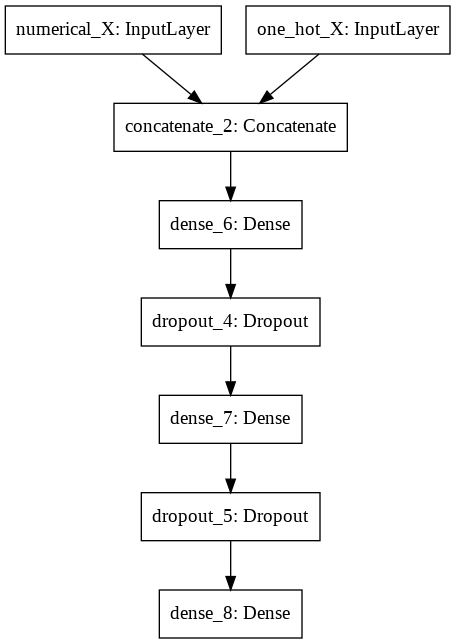

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numerical_X (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
one_hot_X (InputLayer)          [(None, 91)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 97)           0           numerical_X[0][0]                
                                                                 one_hot_X[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          25088       concatenate_2[0][0]   

None

In [45]:
def displaymodel(model):
    '''モデルの構造を表示'''
    display(plot_model(model))
    display(model.summary())


displaymodel(model=classifier)

# モデルの評価

## Kerasの組み込み評価関数

In [46]:
%%time
score = classifier.evaluate(x=test_X, y=test_y, batch_size=BATCH_SIZE)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.7671


'loss : 0.541772186756134, accuracy : 0.7671204805374146'

CPU times: user 113 ms, sys: 13.2 ms, total: 126 ms
Wall time: 114 ms


## sklearnの評価関数

In [47]:
%%time
def predict_classes(model, x):
    '''ラスラベルの予測を取得'''
    return np.argmax(model.predict(x), axis=-1)


# 予測結果の取得
train_y_pred = predict_classes(classifier, train_X)
val_y_pred = predict_classes(classifier, val_X)
test_y_pred = predict_classes(classifier, test_X)


def encode_label_classes(one_hot_encode_y):
    '''ワンホットエンコードをラベルエンコードに変換'''
    return np.argmax(one_hot_encode_y.values, axis=-1)

train_report = classification_report(y_true=encode_label_classes(train_y),
                                     y_pred=train_y_pred)
val_report = classification_report(y_true=encode_label_classes(val_y),
                                   y_pred=val_y_pred)
test_report = classification_report(y_true=encode_label_classes(test_y),
                                    y_pred=test_y_pred)


print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.03      0.05      7477
           1       0.77      1.00      0.87     23781

    accuracy                           0.77     31258
   macro avg       0.88      0.51      0.46     31258
weighted avg       0.82      0.77      0.67     31258

----- -----
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      1900
           1       0.76      1.00      0.86      5915

    accuracy                           0.76      7815
   macro avg       0.88      0.51      0.45      7815
weighted avg       0.82      0.76      0.66      7815

----- -----
              precision    recall  f1-score   support

           0       1.00      0.02      0.03      2310
           1       0.77      1.00      0.87      7459

    accuracy                           0.77      9769
   macro avg       0.88      0.51      0.45      9769
weighted avg       0.82      0.77      0.67      9